In [33]:
pip install gspread pandas gspread-dataframe oauth2client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 kB 4.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import gspread
import pandas as pd
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials

# Set up the credentials
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name("/Users/joshuagoldberg/Desktop/BAClass/chosen-metric-3205800a614d.json", scope)

# Authorize and open the sheet
gc = gspread.authorize(credentials)
spreadsheet_url = "https://docs.google.com/spreadsheets/d/130RPUzMh841eevpbZFV3w3aU8_HhB_Gj8ihJEfwOFGQ/edit"
spreadsheet = gc.open_by_url(spreadsheet_url)

# Load data from the first tab ("pitch_tempo")
pitch_tempo_sheet = spreadsheet.worksheet("pitch_tempo")
pitch_tempo_data = get_as_dataframe(pitch_tempo_sheet)

# Load data from the second tab ("woba")
woba_sheet = spreadsheet.worksheet("woba")
woba_data = get_as_dataframe(woba_sheet)

# Drop empty rows/columns (optional)
pitch_tempo_data = pitch_tempo_data.dropna(how="all").dropna(axis=1, how="all")
woba_data = woba_data.dropna(how="all").dropna(axis=1, how="all")

# Display the data (optional)
print("Pitch Tempo Data:")
print(pitch_tempo_data.head())

print("\nWOBA Data:")
print(woba_data.head())


Pitch Tempo Data:
   entity_id          entity_name entity_code  team_id  total_pitches  \
0   643396.0  Kiner-Falefa, Isiah         Bat    134.0          808.0   
1   545341.0      Grichuk, Randal         Bat    109.0          493.0   
2   623912.0      Ramírez, Harold         Bat    120.0          327.0   
3   657656.0      Laureano, Ramón         Bat    144.0          477.0   
4   621028.0        Newman, Kevin         Bat    109.0          442.0   

   total_pitches.1  total_pitches_empty  median_seconds_empty  \
0            808.0                556.0                14.304   
1            493.0                266.0                14.475   
2            327.0                183.0                14.533   
3            477.0                305.0                14.615   
4            442.0                265.0                14.633   

   total_pitches_onbase  median_seconds_empty.1  freq_hot  freq_warm  \
0                 252.0                  14.304  0.456683   0.542079   
1       

In [51]:
import pandas as pd

# Assuming you have already loaded the datasets as DataFrames
# pitch_tempo_data = pd.read_csv("path_to_pitch_tempo_data.csv")
# woba_data = pd.read_csv("path_to_woba_data.csv")

# Rename the player name columns to a common name (e.g., 'player_name')
pitch_tempo_data.rename(columns={'entity_name': 'player_name', 'median_seconds_empty': 'pitch_tempo_empty'}, inplace=True)
woba_data.rename(columns={'last_name, first_name': 'player_name'}, inplace=True)

# Merge the datasets on 'player_name'
merged_data = pd.merge(pitch_tempo_data, woba_data, on="player_name", how="inner")

# Select the desired columns and create a copy to avoid SettingWithCopyWarning
final_data = merged_data[['player_name', 'pitch_tempo_empty', 'total_pitches_empty', 'woba']].copy()

# Add a percentile column for total_pitches_empty
final_data['total_pitches_empty_percentile'] = final_data['total_pitches_empty'].rank(pct=True)

# Sort by pitch_tempo_empty in descending order
final_data_sorted = final_data.sort_values(by='total_pitches_empty', ascending=False)

# Display the resulting dataframe
print(final_data_sorted)


           player_name  pitch_tempo_empty  total_pitches_empty   woba  \
311    Schwarber, Kyle             15.892                967.0  0.366   
56     India, Jonathan             15.058                953.0  0.333   
354         Soto, Juan             16.495                947.0  0.421   
145  Henderson, Gunnar             15.339                918.0  0.381   
143    Torres, Gleyber             15.330                884.0  0.313   
..                 ...                ...                  ...    ...   
328  Soderstrom, Tyler             16.018                204.0  0.322   
191        Ahmed, Nick             15.476                202.0  0.248   
90        Carter, Evan             15.183                200.0  0.278   
262    Carpenter, Matt             15.663                196.0  0.303   
2      Ramírez, Harold             14.533                183.0  0.265   

     total_pitches_empty_percentile  
311                        1.000000  
56                         0.997214  
354      

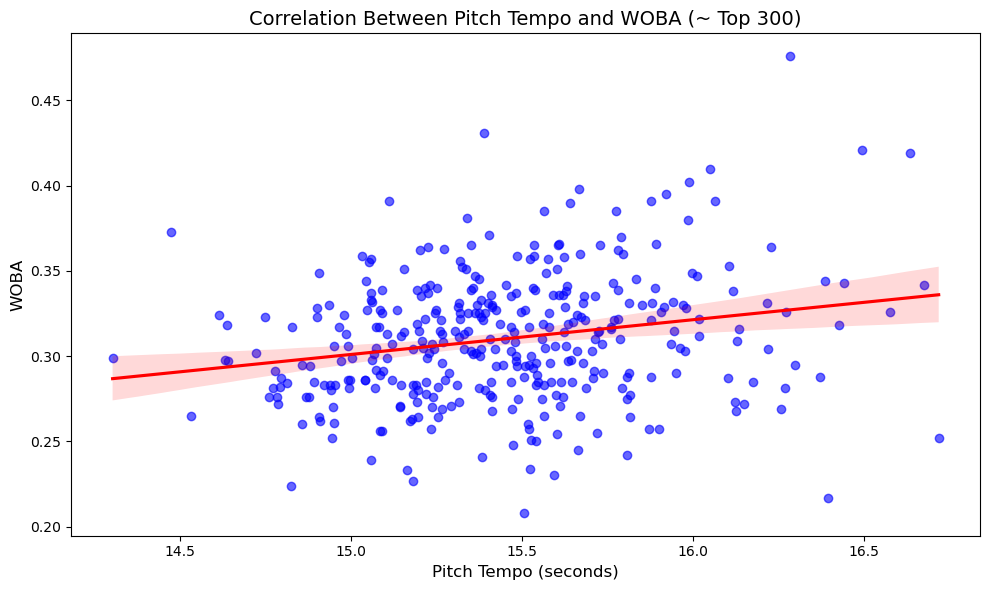

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the `final_data_sorted` DataFrame

# Plot settings
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the scatterplot with regression line
sns.regplot(
    data=final_data_sorted,
    x='pitch_tempo_empty',
    y='woba',
    scatter_kws={'color': 'blue', 'alpha': 0.6},  # Customize scatter points
    line_kws={'color': 'red'},  # Customize regression line
)

# Add titles and labels
plt.title('Correlation Between Pitch Tempo and WOBA (~ Top 300)', fontsize=14)
plt.xlabel('Pitch Tempo (seconds)', fontsize=12)
plt.ylabel('WOBA', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [57]:
import numpy as np
from scipy.stats import pearsonr

# Calculate correlation coefficient (Pearson's r) and p-value
correlation_coefficient, p_value = pearsonr(final_data_sorted['pitch_tempo_empty'], final_data_sorted['woba'])

# Print key metrics
print(f"Correlation Coefficient (r): {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4e}")

# Additional statistics
x_mean = final_data_sorted['pitch_tempo_empty'].mean()
y_mean = final_data_sorted['woba'].mean()
x_std = final_data_sorted['pitch_tempo_empty'].std()
y_std = final_data_sorted['woba'].std()

print("\nDescriptive Statistics:")
print(f"Mean of Pitch Tempo: {x_mean:.2f} seconds")
print(f"Mean of WOBA: {y_mean:.4f}")
print(f"Standard Deviation of Pitch Tempo: {x_std:.2f} seconds")
print(f"Standard Deviation of WOBA: {y_std:.4f}")


Correlation Coefficient (r): 0.2218
P-value: 2.2260e-05

Descriptive Statistics:
Mean of Pitch Tempo: 15.45 seconds
Mean of WOBA: 0.3101
Standard Deviation of Pitch Tempo: 0.41 seconds
Standard Deviation of WOBA: 0.0373


In [59]:
# Function to identify outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for 'pitch_tempo_empty' and 'woba'
outliers_pitch_tempo, lower_pitch, upper_pitch = detect_outliers_iqr(final_data_sorted, 'pitch_tempo_empty')
outliers_woba, lower_woba, upper_woba = detect_outliers_iqr(final_data_sorted, 'woba')

# Print outlier details
print("Outliers in 'pitch_tempo_empty':")
print(outliers_pitch_tempo[['player_name', 'pitch_tempo_empty']])
print(f"Lower Bound: {lower_pitch:.2f}, Upper Bound: {upper_pitch:.2f}\n")

print("Outliers in 'woba':")
print(outliers_woba[['player_name', 'woba']])
print(f"Lower Bound: {lower_woba:.4f}, Upper Bound: {upper_woba:.4f}")


Outliers in 'pitch_tempo_empty':
             player_name  pitch_tempo_empty
354           Soto, Juan             16.495
352       Martinez, J.D.             16.427
353    Walker, Christian             16.441
0    Kiner-Falefa, Isiah             14.304
356         Tucker, Kyle             16.635
355       Realmuto, J.T.             16.577
358         Duvall, Adam             16.719
357       Casas, Triston             16.675
Lower Bound: 14.44, Upper Bound: 16.42

Outliers in 'woba':
         player_name   woba
354       Soto, Juan  0.421
166   Ohtani, Shohei  0.431
347     Judge, Aaron  0.476
330  Witt Jr., Bobby  0.410
325  Alvarez, Yordan  0.402
356     Tucker, Kyle  0.419
201    Anderson, Tim  0.208
Lower Bound: 0.2147, Upper Bound: 0.4008


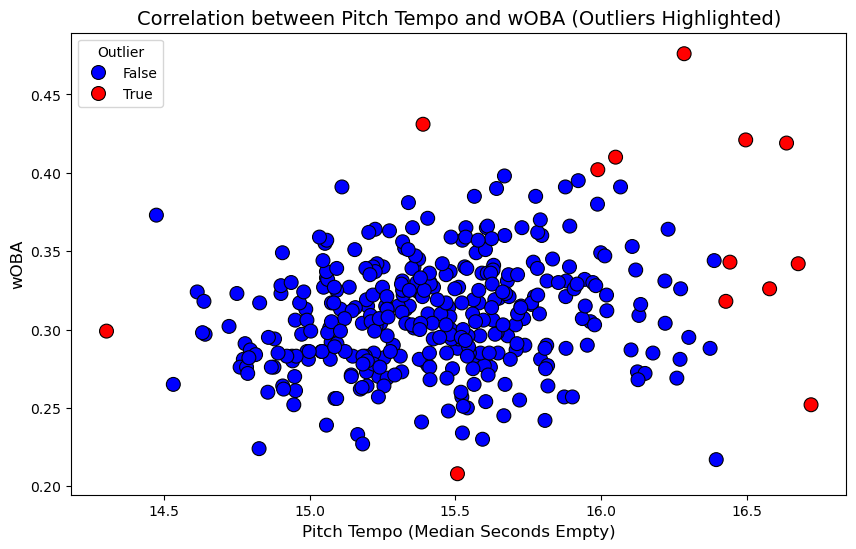

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Detect outliers using IQR method (you can choose other methods too)
outliers_pitch_tempo, lower_pitch, upper_pitch = detect_outliers_iqr(final_data_sorted, 'pitch_tempo_empty')
outliers_woba, lower_woba, upper_woba = detect_outliers_iqr(final_data_sorted, 'woba')

# Merge the outliers back into the dataset for easy visualization
final_data_sorted['is_outlier'] = final_data_sorted['player_name'].isin(outliers_pitch_tempo['player_name']) | final_data_sorted['player_name'].isin(outliers_woba['player_name'])

# Set up the correlation plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data_sorted, x='pitch_tempo_empty', y='woba', hue='is_outlier', palette={True: 'red', False: 'blue'}, marker='o', s=100, edgecolor='black')

# Add labels and title
plt.title("Correlation between Pitch Tempo and wOBA (Outliers Highlighted)", fontsize=14)
plt.xlabel("Pitch Tempo (Median Seconds Empty)", fontsize=12)
plt.ylabel("wOBA", fontsize=12)
plt.legend(title='Outlier', loc='upper left')

# Display the plot
plt.show()


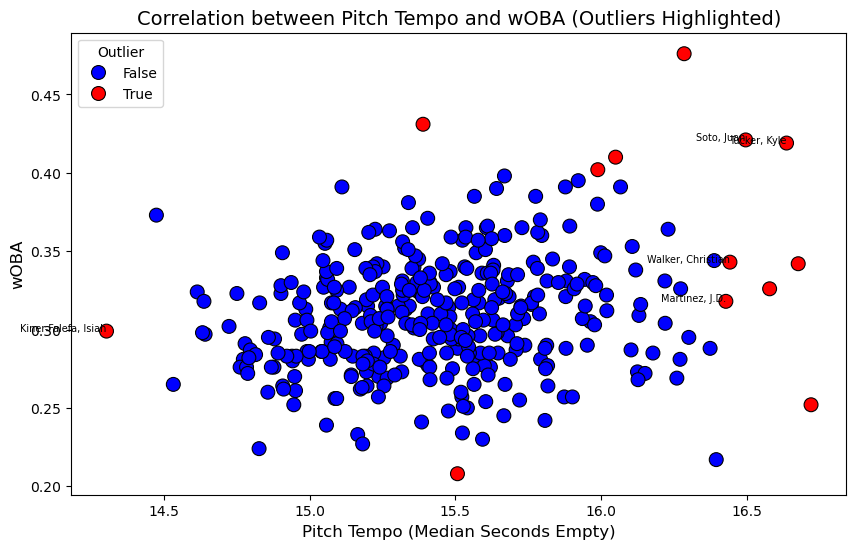

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for both pitch_tempo_empty and woba
outliers_pitch_tempo, lower_pitch, upper_pitch = detect_outliers_iqr(final_data_sorted, 'pitch_tempo_empty')
outliers_woba, lower_woba, upper_woba = detect_outliers_iqr(final_data_sorted, 'woba')

# Merge the outliers back into the dataset for easy visualization
final_data_sorted['is_outlier'] = final_data_sorted['player_name'].isin(outliers_pitch_tempo['player_name']) | final_data_sorted['player_name'].isin(outliers_woba['player_name'])

# Set up the correlation plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data_sorted, x='pitch_tempo_empty', y='woba', hue='is_outlier', palette={True: 'red', False: 'blue'}, marker='o', s=100, edgecolor='black')

# Annotate extreme outliers (top 5 most extreme outliers based on both variables)
outliers_combined = pd.concat([outliers_pitch_tempo, outliers_woba]).drop_duplicates()
top_outliers = outliers_combined.head(5)  # Get the top 5 extreme outliers, you can adjust this as needed

for _, row in top_outliers.iterrows():
    plt.text(row['pitch_tempo_empty'], row['woba'], row['player_name'], fontsize=7, ha='right', color='black')

# Add labels and title
plt.title("Correlation between Pitch Tempo and wOBA (Outliers Highlighted)", fontsize=14)
plt.xlabel("Pitch Tempo (Median Seconds Empty)", fontsize=12)
plt.ylabel("wOBA", fontsize=12)
plt.legend(title='Outlier', loc='upper left')

# Display the plot
plt.show()


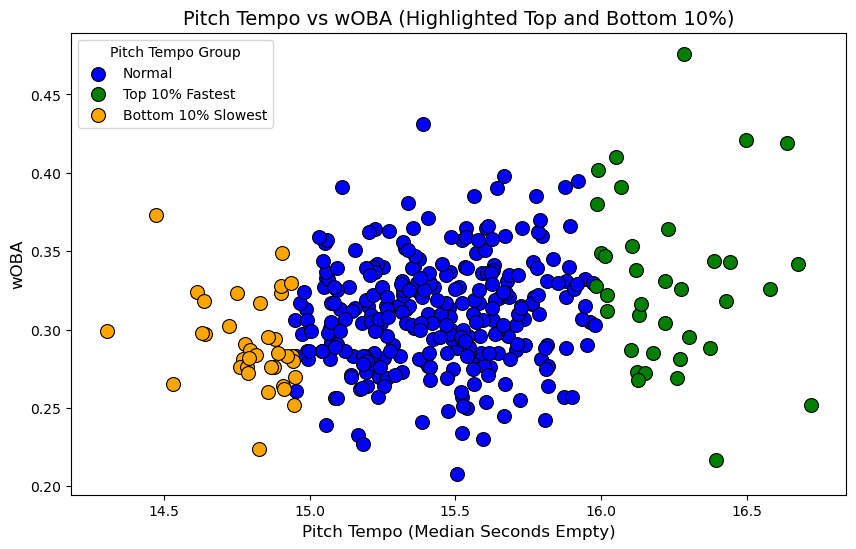

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the 10th and 90th percentiles of pitch_tempo_empty
top_10_percentile = final_data_sorted['pitch_tempo_empty'].quantile(0.90)
bottom_10_percentile = final_data_sorted['pitch_tempo_empty'].quantile(0.10)

# Create a new column 'highlight' to mark the top and bottom 10% pitch tempos
final_data_sorted['highlight'] = final_data_sorted['pitch_tempo_empty'].apply(
    lambda x: 'top_10%' if x >= top_10_percentile else ('bottom_10%' if x <= bottom_10_percentile else 'normal')
)

# Set up the correlation plot
plt.figure(figsize=(10, 6))

# Plot the normal points in blue
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'normal'], 
                x='pitch_tempo_empty', y='woba', color='blue', label='Normal', marker='o', s=100, edgecolor='black')

# Plot the top 10% pitch tempos in green
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'top_10%'], 
                x='pitch_tempo_empty', y='woba', color='green', label='Top 10% Fastest', marker='o', s=100, edgecolor='black')

# Plot the bottom 10% pitch tempos in orange
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%'], 
                x='pitch_tempo_empty', y='woba', color='orange', label='Bottom 10% Slowest', marker='o', s=100, edgecolor='black')

# Add labels and title
plt.title("Pitch Tempo vs wOBA (Highlighted Top and Bottom 10%)", fontsize=14)
plt.xlabel("Pitch Tempo (Median Seconds Empty)", fontsize=12)
plt.ylabel("wOBA", fontsize=12)

# Display the legend and plot
plt.legend(title='Pitch Tempo Group', loc='upper left')
plt.show()


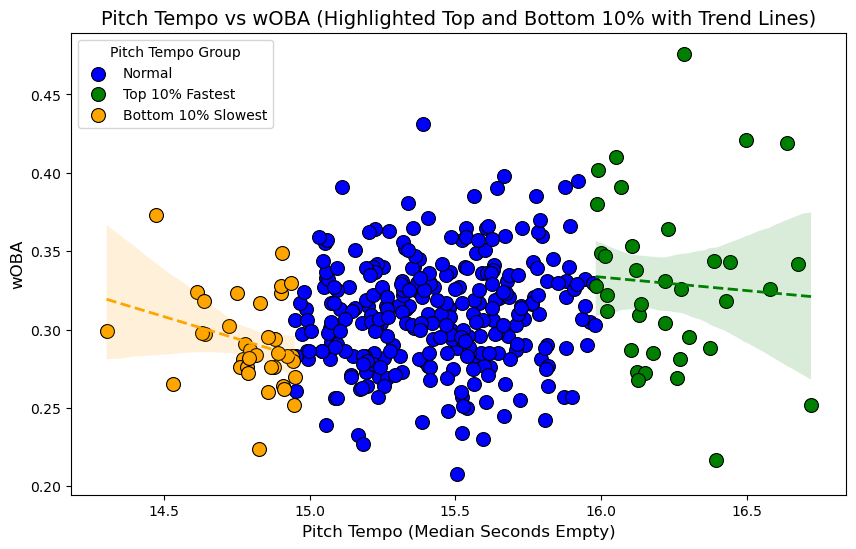

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the 10th and 90th percentiles of pitch_tempo_empty
top_10_percentile = final_data_sorted['pitch_tempo_empty'].quantile(0.90)
bottom_10_percentile = final_data_sorted['pitch_tempo_empty'].quantile(0.10)

# Create a new column 'highlight' to mark the top and bottom 10% pitch tempos
final_data_sorted['highlight'] = final_data_sorted['pitch_tempo_empty'].apply(
    lambda x: 'top_10%' if x >= top_10_percentile else ('bottom_10%' if x <= bottom_10_percentile else 'normal')
)

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the normal points in blue
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'normal'], 
                x='pitch_tempo_empty', y='woba', color='blue', label='Normal', marker='o', s=100, edgecolor='black')

# Plot the top 10% pitch tempos in green
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'top_10%'], 
                x='pitch_tempo_empty', y='woba', color='green', label='Top 10% Fastest', marker='o', s=100, edgecolor='black')

# Plot the bottom 10% pitch tempos in orange
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%'], 
                x='pitch_tempo_empty', y='woba', color='orange', label='Bottom 10% Slowest', marker='o', s=100, edgecolor='black')

# Add trend line for top 10% (fastest pitch tempos)
sns.regplot(data=final_data_sorted[final_data_sorted['highlight'] == 'top_10%'], 
            x='pitch_tempo_empty', y='woba', scatter=False, color='green', line_kws={'linewidth': 2, 'linestyle': '--'})

# Add trend line for bottom 10% (slowest pitch tempos)
sns.regplot(data=final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%'], 
            x='pitch_tempo_empty', y='woba', scatter=False, color='orange', line_kws={'linewidth': 2, 'linestyle': '--'})

# Add labels and title
plt.title("Pitch Tempo vs wOBA (Highlighted Top and Bottom 10% with Trend Lines)", fontsize=14)
plt.xlabel("Pitch Tempo (Median Seconds Empty)", fontsize=12)
plt.ylabel("wOBA", fontsize=12)

# Display the legend and plot
plt.legend(title='Pitch Tempo Group', loc='upper left')
plt.show()


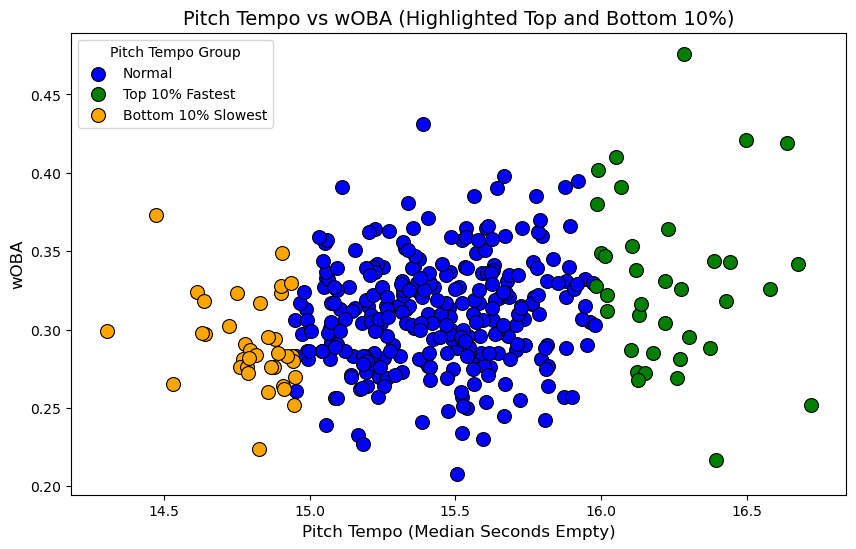


Overall Statistics:
count    359.00
mean      15.45
std        0.41
min       14.30
25%       15.18
50%       15.42
75%       15.68
max       16.72
Name: pitch_tempo_empty, dtype: float64
Overall Standard Deviation: 0.41
Overall IQR: 0.50

Top 10% Fastest Pitch Tempos Statistics:
count    36.00
mean     16.23
std       0.21
min      15.98
25%      16.09
50%      16.20
75%      16.38
max      16.72
Name: pitch_tempo_empty, dtype: float64
Top 10% Standard Deviation: 0.21
Top 10% IQR: 0.28

Bottom 10% Slowest Pitch Tempos Statistics:
count    36.00
mean     14.80
std       0.15
min      14.30
25%      14.76
50%      14.83
75%      14.90
max      14.95
Name: pitch_tempo_empty, dtype: float64
Bottom 10% Standard Deviation: 0.15
Bottom 10% IQR: 0.14


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the 10th and 90th percentiles of pitch_tempo_empty
top_10_percentile = final_data_sorted['pitch_tempo_empty'].quantile(0.90)
bottom_10_percentile = final_data_sorted['pitch_tempo_empty'].quantile(0.10)

# Create a new column 'highlight' to mark the top and bottom 10% pitch tempos
final_data_sorted['highlight'] = final_data_sorted['pitch_tempo_empty'].apply(
    lambda x: 'top_10%' if x >= top_10_percentile else ('bottom_10%' if x <= bottom_10_percentile else 'normal')
)

# Set up the correlation plot
plt.figure(figsize=(10, 6))

# Plot the normal points in blue
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'normal'], 
                x='pitch_tempo_empty', y='woba', color='blue', label='Normal', marker='o', s=100, edgecolor='black')

# Plot the top 10% pitch tempos in green
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'top_10%'], 
                x='pitch_tempo_empty', y='woba', color='green', label='Top 10% Fastest', marker='o', s=100, edgecolor='black')

# Plot the bottom 10% pitch tempos in orange
sns.scatterplot(data=final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%'], 
                x='pitch_tempo_empty', y='woba', color='orange', label='Bottom 10% Slowest', marker='o', s=100, edgecolor='black')

# Add labels and title
plt.title("Pitch Tempo vs wOBA (Highlighted Top and Bottom 10%)", fontsize=14)
plt.xlabel("Pitch Tempo (Median Seconds Empty)", fontsize=12)
plt.ylabel("wOBA", fontsize=12)

# Display the legend and plot
plt.legend(title='Pitch Tempo Group', loc='upper left')
plt.show()

# Print statistics for overall dataset, top 10%, and bottom 10%

# Overall statistics
overall_stats = final_data_sorted['pitch_tempo_empty'].describe().round(2)

# Top 10% statistics
top_10_stats = final_data_sorted[final_data_sorted['highlight'] == 'top_10%']['pitch_tempo_empty'].describe().round(2)

# Bottom 10% statistics
bottom_10_stats = final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%']['pitch_tempo_empty'].describe().round(2)

# Calculate variability: standard deviation and IQR
overall_std = round(final_data_sorted['pitch_tempo_empty'].std(), 2)
top_10_std = round(final_data_sorted[final_data_sorted['highlight'] == 'top_10%']['pitch_tempo_empty'].std(), 2)
bottom_10_std = round(final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%']['pitch_tempo_empty'].std(), 2)

overall_iqr = final_data_sorted['pitch_tempo_empty'].quantile(0.75) - final_data_sorted['pitch_tempo_empty'].quantile(0.25)
top_10_iqr = final_data_sorted[final_data_sorted['highlight'] == 'top_10%']['pitch_tempo_empty'].quantile(0.75) - final_data_sorted[final_data_sorted['highlight'] == 'top_10%']['pitch_tempo_empty'].quantile(0.25)
bottom_10_iqr = final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%']['pitch_tempo_empty'].quantile(0.75) - final_data_sorted[final_data_sorted['highlight'] == 'bottom_10%']['pitch_tempo_empty'].quantile(0.25)

# Print rounded statistics and variability
print("\nOverall Statistics:")
print(overall_stats)
print(f"Overall Standard Deviation: {overall_std}")
print(f"Overall IQR: {overall_iqr:.2f}")

print("\nTop 10% Fastest Pitch Tempos Statistics:")
print(top_10_stats)
print(f"Top 10% Standard Deviation: {top_10_std}")
print(f"Top 10% IQR: {top_10_iqr:.2f}")

print("\nBottom 10% Slowest Pitch Tempos Statistics:")
print(bottom_10_stats)
print(f"Bottom 10% Standard Deviation: {bottom_10_std}")
print(f"Bottom 10% IQR: {bottom_10_iqr:.2f}")
